In [4]:
#from datasets import load_dataset
import pandas as pd

In [ ]:
# Load the dataset from Hugging Face
# dataset = load_dataset("amazon_polarity")

#train = pd.dataFrame(dataset['train'])
#test = pd.dataFrame(dataset['test'])

#train.to_csv('../data/amazon_train.csv', index=False)
#test.to_csv('../data/amazon_train.csv', index=False)

In [10]:
train = pd.read_csv('../data/amazon_train.csv')
test = pd.read_csv('../data/amazon_test.csv')

## Goal: Prep the Dataset for a Classifier
### 🔎 Dataset Structure Recap:
- label: 0 (negative), 1 (positive)
- title: Short headline
- content: Full review text


In [11]:
train.head(3)

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...


### STEP 1: Preprocessing the Text

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

We will use Natural Language Toolkit (NLTK), the python library that works with human language data, to process the text entries

NLTK allows us to perform common NLP Task, like:
- Tokenization
- Stopword Removal
- Stemming & Lemmatization 
- Part of Speech tagging
- Sentence Segmentation
- Named Entity Recognition
- Stopword Removal
- Stemming & Lemmatization 
- POS tagging
- Sentence Segmentation
- Named Entity Recognition

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

# These are common words like “the”, “is”, “in”, “and”
# which don’t add much meaning in sentiment tasks.
stop_words = set(stopwords.words('english'))

#This reduces words to their base or dictionary form. Example:
# running → run
# better → good
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandyyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandyyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Here, we define our function to clean the text entries. The cleaning process includes:
- Removing stop words, punctuation, and numbers
- Lemmatizing the words
- Converting text to lowercase

In [8]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = text.split()  # Split into words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)  # Join words back into a single string

In [12]:
df = train
df["text"] = df["title"] + " " + df["content"]
df["clean_text"] = df["text"].apply(clean_text)

We can see that the `clean_text` column is entirely in lowercase, and stop words, numbers and punctuation have been removed effectively.

In [13]:
df.head(3)

,label,title,content,text,clean_text
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,Stuning even for the non-gamer This sound trac...,stuning even nongamer sound track beautiful pa...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,The best soundtrack ever to anything. I'm read...,best soundtrack ever anything im reading lot r...
2,1,Amazing!,This soundtrack is my favorite music of all ti...,Amazing! This soundtrack is my favorite music ...,amazing soundtrack favorite music time hand in...


### STEP 2: Exploratory Data Analysis (EDA)

After making sure our text valued has been properly handle. We can visiualization our dataset

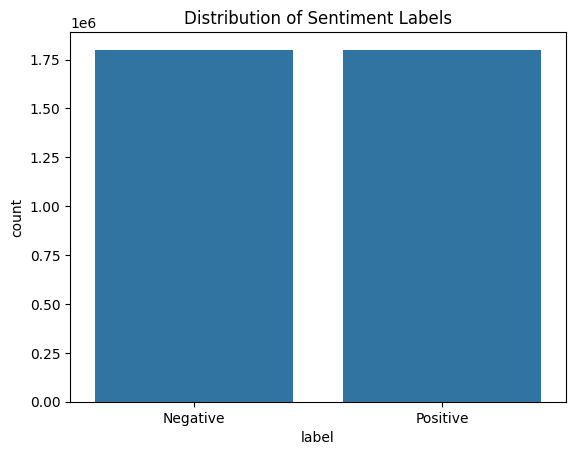

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

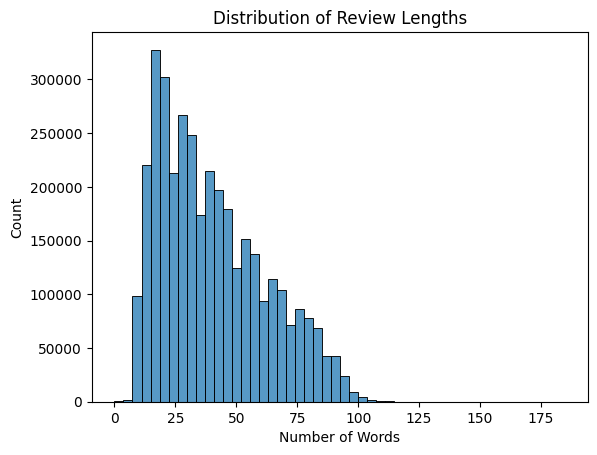

In [11]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.show()

In [ ]:
from wordcloud import WordCloud

positive_text = ' '.join(df[df['label'] == 1]['clean_text'].head(5000).tolist())
negative_text = ' '.join(df[df['label'] == 0]['clean_text'].head(5000).tolist())

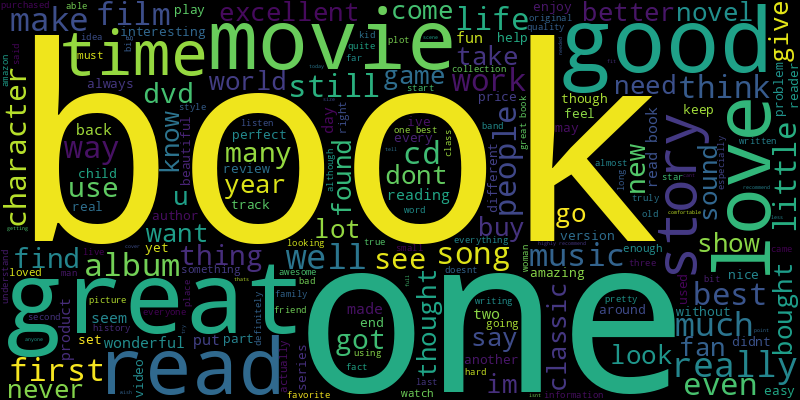

In [ ]:
#Positive
WordCloud(width=800, height=400).generate(positive_text).to_image()

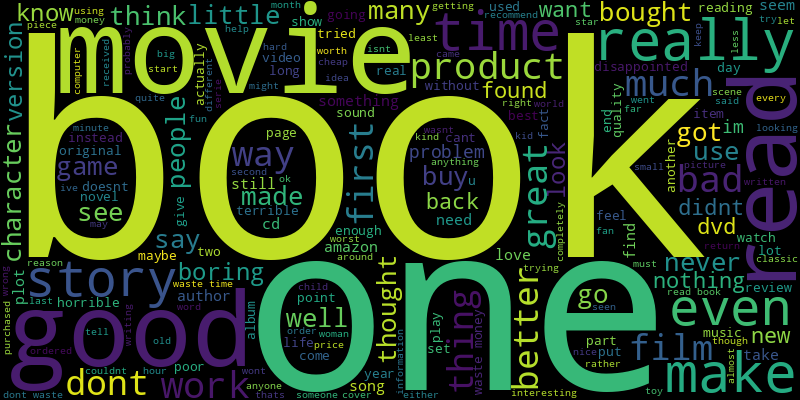

In [16]:
# Negative
WordCloud(width=800, height=400).generate(negative_text).to_image()


### Top frequent words per class (use CountVectorizer)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_text'].head(10000))

# Get word names
words = vectorizer.get_feature_names_out()

# Make word count DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=words)
word_counts['label'] = df['label']

In [17]:
top_words_per_class = {}

# For each unique class label
for label in df['label'].unique():
    # Filter rows of that class
    class_words = word_counts[word_counts['label'] == label].drop('label', axis=1)
    # Sum word occurrences
    top_words = class_words.sum().sort_values(ascending=False)
    # Store top N words (e.g., top 5)
    top_words_per_class[label] = top_words.head(10)

# Display results
for label, top_words in top_words_per_class.items():
    print(f"\nTop words for class '{label}':")
    print(top_words)


Top words for class '1':
book     3861
great    2089
one      1936
good     1638
read     1574
like     1320
movie    1295
time     1135
love     1036
would     943
dtype: int64

Top words for class '0':
book     3683
one      2119
movie    1732
like     1570
would    1438
get      1285
time     1274
dont     1240
read     1238
good     1137
dtype: int64


### N-gram analysis:
An N-gram is a contiguous sequence of n items (usually words) from a given text.

- Unigram (1-gram): "I", "love", "cats"
- Bigram (2-gram): "I love", "love cats"
- Trigram (3-gram): "I love cats"

#### Why Use N-gram Analysis?
N-grams help:
- Identify common phrases or word pairings in text.
- Improve feature representation in NLP models.
- Understand how word combinations differ between classes (e.g., positive vs. negative reviews).
- Extract collocations (frequently co-occurring words).

In [ ]:
positive_texts = df[df['label'] == 1]['clean_text']
negative_texts = df[df['label'] == 0]['clean_text']

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2))
X_pos = vectorizer.fit_transform(positive_texts)

# Get bigram names and their counts
bigrams = vectorizer.get_feature_names_out()
counts = X_pos.sum(axis=0).A1  # convert sparse matrix to flat array

# Create a DataFrame for sorting
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# bigrams that appear most in positive reviews
print(bigram_freq.head(10))  # Top 10 bigrams

                    bigram  count
13594044         read book  59164
11757575          one best  52867
7840206   highly recommend  51215
19127046          year old  46406
7242755         great book  44219
19002281   would recommend  36899
18908566        work great  30933
19117066          year ago  29981
7094955          good book  27863
7264570      great product  26268


In [32]:
bigrams = vectorizer.get_feature_names_out()
X_neg = vectorizer.fit_transform(negative_texts)
counts = X_neg.sum(axis=0).A1  # convert sparse matrix to flat array

# Create a DataFrame for sorting
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)

# bigrams that appear most in positive reviews
print(bigram_freq.head(10))  # Top 10 bigrams

                   bigram  count
18577986      waste money  86188
18579988       waste time  53401
4791034        dont waste  52703
4783322          dont buy  48269
13566869        read book  40031
10946512      much better  38237
4786658         dont know  37008
19292512         year old  36512
19152623  would recommend  35230
14621907       save money  32923


### Modeling – Logistic Regression

Logistic Regression is a widely used and effective baseline model for binary classification tasks such as sentiment analysis. It is particularly well-suited for high-dimensional, sparse data — which is common in text classification when using features like TF-IDF or Bag-of-Words.

In this case, I chose Logistic Regression because:

- ✅ It scales well to large datasets such as Amazon reviews.
- ✅ It performs efficiently on sparse text data.
- ✅ It is easy to implement, interpret, and tune.
- ✅ It provides strong baseline performance with minimal preprocessing.

While more complex models like LSTM or Transformer-based architectures may outperform it on larger or more nuanced datasets, Logistic Regression offers a strong starting point for understanding the signal in the text and evaluating model performance quickly.


In [15]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=df['label'])

In [43]:
# Vectorize text using Bag of Words
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [44]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
y_pred = lr_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/Users/sandyyang/SentimentAnalysis/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8974402777777778
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90    360000
           1       0.89      0.90      0.90    360000

    accuracy                           0.90    720000
   macro avg       0.90      0.90      0.90    720000
weighted avg       0.90      0.90      0.90    720000



### Interpretation of Results: Logistic Regression

The overall **accuracy** of the Logistic Regression model is **0.90**, meaning it correctly predicts sentiment 90% of the time on the test data.

- The **precision** is 0.90, which means that when the model predicts a certain class (positive or negative), it's correct 90% of the time.
- The **recall** is also 0.90, indicating that the model successfully captures 90% of all actual instances of each class.
- The **F1-score**, the harmonic mean of precision and recall, is also 0.90. This suggests that the model achieves a good balance between precision (avoiding false positives) and recall (avoiding false negatives).

This indicates that the model is well-balanced, with no significant bias toward either class (positive or negative sentiment), and performs consistently across both.

### Modeling - Multinomial Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB

In [46]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred = nb_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8486263888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85    360000
           1       0.86      0.84      0.85    360000

    accuracy                           0.85    720000
   macro avg       0.85      0.85      0.85    720000
weighted avg       0.85      0.85      0.85    720000



### Modeling: LSTM (Long Short-Term Memory)

What is LSTM? 

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) designed to memorize long-term dependencies. It is useful to analyze sequential data -- data where order matters.

Common usecase:
- Sentiment Analysis on reviews
- Speech Recognization
- Stock Price Prediction
- Machine translation

We will use LSTM to train the model. Here's what we'll do:
- Tokenize the text input: 

Unlike `CountVectorizer`, which just counts word frequency, we'll use a Tokenizer to convert the top 5,000 most frequent words into integers, keeping the order of the words — which is important for LSTM to understand the sequence.

- Pad the sequences:

Since LSTM requires inputs to have the same length, we'll use `pad_sequences()` to make sure all sequences are the same length by adding zeros where needed.

- Use  `Embedding` layer: 

We'll map word indices to dense vectors (word embeddings), so the model can learn the "meaning" of each word.
- Use `Bidirectional`(LSTM): 

We'll wrap our LSTM in a `Bidirectional` layer so that it reads the sentence both forward and backward. This helps the model understand context more accurately, especially in complex sentences.
- Train the model:

We'll compile the model with a loss function and optimizer, then fit it to our training data and evaluate its performance.

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout # Prevent overfitting



In [49]:
# Converts 'clean_text' into numbers
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit the tokenizer only on training text
tokenizer.fit_on_texts(X_train)

# Convert text to sequences (word indexes)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [50]:
# Pad sequences to the same length
max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


In [ ]:
#Build the architecture of your neural network, layer by layer
model = Sequential([
    Embedding(input_dim=max_words, # use top 5k frequent words
              output_dim=128), # Each word will be turned into a 128-dimensional vector
              Bidirectional(LSTM(64)), # Reads the words in order, remembering important ones
              Dropout(0.5),
              Dense(1, activation='sigmoid'), # Decides if the overall meaning is positive or negative
        ])


In [ ]:
# how the model learns  (training configuration)
model.compile(loss='binary_crossentropy', # What error we’re trying to minimize
              optimizer='adam', # What method we use to minimize the error
              metrics=['accuracy']) # What we track to evaluate model performance


In [57]:
# Train the model
model.fit(X_train_pad, y_train, epochs=3, batch_size=64, 
          validation_split=0.2)


Epoch 1/3
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 5852s 162ms/step - accuracy: 0.8909 - loss: 0.2621 - val_accuracy: 0.9159 - val_loss: 0.2080
Epoch 2/3
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 5811s 161ms/step - accuracy: 0.9191 - loss: 0.2043 - val_accuracy: 0.9192 - val_loss: 0.2032
Epoch 3/3
36000/36000 ━━━━━━━━━━━━━━━━━━━━ 6032s 168ms/step - accuracy: 0.9259 - loss: 0.1895 - val_accuracy: 0.9221 - val_loss: 0.1955


In [58]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 671s 30ms/step - accuracy: 0.9214 - loss: 0.1968
Test Accuracy: 0.9221


In [ ]:
model.save("sentiment_lstm_model.keras")

In [63]:
import pickle
with open("../src/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)